In [1]:
pip install eli5

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import make_pipeline


import eli5
from eli5.sklearn import PermutationImportance

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


# LOAD DATASET

In [35]:
df = pd.read_csv( "/content/gdrive/My Drive/Datasets/The_movies_dataset/The_movies_dataset_preprocessed.csv")
df

budget      id    imdb_id  ...  United States of America  cast crew
0     30000000     862  tt0114709  ...                       1.0    12   52
1     65000000    8844  tt0113497  ...                       1.0    12   14
2     16000000   31357  tt0114885  ...                       1.0     9    7
3     60000000     949  tt0113277  ...                       1.0    40   53
4     35000000    9091  tt0114576  ...                       1.0     5    7
...        ...     ...        ...  ...                       ...   ...  ...
5315  11000000  395834  tt5362988  ...                       1.0     9   10
5316  12000000   24049  tt0479751  ...                       0.0     4   10
5317    800000   62757  tt0933361  ...                       0.0     2    0
5318   2000000   63281  tt1718881  ...                       0.0     1    0
5319   5000000   63898  tt1110037  ...                       0.0     1    0

[5320 rows x 44 columns]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   budget                    5320 non-null   int64  
 1   id                        5320 non-null   int64  
 2   imdb_id                   5320 non-null   object 
 3   language                  5320 non-null   float64
 4   popularity                5320 non-null   float64
 5   release_date              5320 non-null   object 
 6   revenue                   5320 non-null   int64  
 7   runtime                   5320 non-null   float64
 8   keyword                   5320 non-null   int64  
 9   Day                       5320 non-null   int64  
 10  Year                      5320 non-null   int64  
 11  Foreign                   5320 non-null   float64
 12  Thriller                  5320 non-null   float64
 13  History                   5320 non-null   float64
 14  Mystery 

# PREPARE DATASET

##### 1) Remove features with high inter-correlation
##### 2) Split dataset into train and test sets

In [37]:
def get_set_for_lr(df):
  """
  function to drop columns `id`, `release_date`, `imdb_id`
  """
  movies_reg = df
  movies_reg.drop(['id','release_date','imdb_id'], axis=1, inplace=True)
  return movies_reg


def split_x_and_y(movies_reg):
  """
  function to segregate features from y-labels
  """
  y = movies_reg.revenue
  movies_reg.drop(['revenue'], axis=1, inplace=True)
  return movies_reg, y

def corr_stuff(df):
  """
  function to drop features that have high inter-correlation
  - This reduces data dimensionality and speeds up model training.
  """
  criteria = 0.6
  corr = df.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
      for j in range(i+1, corr.shape[0]):
          if corr.iloc[i,j] >= criteria:
              if columns[j]:
                  columns[j] = False
  selected_columns = df.columns[columns]
  data = df[selected_columns]
  return data, selected_columns

def get_regression_sets(movies):
  movies_reg=get_set_for_lr(movies)
  x,y = split_x_and_y(movies_reg)
  x, fc = corr_stuff(x)
  
  # split training and testing data
  X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)
  return  X_train, X_test, Y_train, Y_test, fc
  
X_train, X_test, Y_train, Y_test, final_columns = get_regression_sets(df)

# HELPER FUNCTIONS

In [38]:
def feature_importance(model, color, model_name):
  """
  function to visualize importance of different features
  """
  all_cols = X_train.columns.values.tolist()
  importances = model.feature_importances_
  indices = np.argsort(importances)

  fig, ax = plt.subplots(figsize = (10, 8))
  ax.barh(range(len(importances)), importances[indices], color = color)
  ax.set_yticks(range(len(importances)))
  _ = ax.set_yticklabels(np.array(all_cols)[indices])
  
  fig.suptitle(f"Feature Importance with {model_name}")
  ax.set_ylabel("Feature Name")

  return

In [39]:
def get_cv_score(model, X_train, Y_train, X_test, Y_test, cv = 3):
  """
  function to return cross validation score
  """
  if cv == 1:
    regr.fit(X_train, Y_train)
    return regr.score(X_test, Y_test)
  
  return cross_val_score(model,X_train,Y_train,scoring="r2",cv=cv).mean()



def print_metrics(model, y_pred_train, y_pred_test, X_train, Y_train, X_test, Y_test):
  """
  function to print various metrics
  """
  print('Training Dataset:')
  print('R2 Score = ', r2_score(Y_train, y_pred_train))
  print('RMSE = ', np.sqrt(mean_squared_error(Y_train, y_pred_train)))
  
  print('\nTesting Dataset:')
  print('R2 Score = ', r2_score(Y_test, y_pred_test))
  print('RMSE = ', np.sqrt(mean_squared_error(Y_test, y_pred_test)))

  print(f"\nCross Validation R2 Score = {get_cv_score(model, X_train, Y_train, X_test, Y_test)}")

  return
  


def plot_pred_act(y_pred, Y_act, title):
  """
  function to plot a scatter plot of predicted values relative the true values 
  """
  x, y = y_pred, Y_act
  fig, ax = plt.subplots()
  ax.scatter(x, y, s = 2, c='blue')
  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)

  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  
  plt.show()

  return



def plot_for_bias_variance(Y_test_pred, Y_train_pred,Y_test,Y_train,title):
  """
  wrapper function to `plot_pred_act` for easy plotting of train and test sets
  """
  plot_pred_act(Y_test_pred, Y_test, title+" - (Test)")
  print("\n")
  plot_pred_act(Y_train_pred, Y_train,title+ " - (Train)")

  return

In [40]:
def plot_coefficients(model, color):
  """
  function to plot coefficients learned in regression
  """

  # Interpret the coefficients
  c = model.coef_
  feature_names = final_columns
  print(c)
  print(feature_names)

  # Coefficients of genre features 
  genre_labels = feature_names[7:27]
  genre_coefs = c[7:27]
  genre_coefs, genre_labels = zip(*sorted(zip(genre_coefs, genre_labels)))
  
  coefs = pd.DataFrame(genre_coefs, columns = ["Coefficients"], index = genre_labels)
  coefs.plot(kind = "barh", figsize = (9, 7), color = color)
  plt.axvline(x = 0, color = ".5")
  plt.subplots_adjust(left = 0.3)

  # Coefficients of country features 
  country_labels = feature_names[29:-2]
  country_coefs = c[29:-2]
  country_coefs, country_labels = zip(*sorted(zip(country_coefs, country_labels)))
  
  coefs = pd.DataFrame(country_coefs, columns = ["Coefficients"], index = country_labels)
  coefs.plot(kind = "barh", figsize = (9, 7), color = color)
  plt.axvline(x = 0, color = ".5")
  plt.subplots_adjust(left = 0.3)

  # Other features
  other_labels = np.concatenate([feature_names[:7], feature_names[-2:], feature_names[27:29]])
  other_coefs = np.concatenate([c[:7], c[-2:], c[27:29]])
  other_coefs, other_labels = zip(*sorted(zip(other_coefs, other_labels)))
  
  coefs = pd.DataFrame(other_coefs, columns = ["Coefficients"], index = other_labels)
  coefs.plot(kind = "barh", figsize = (9, 7), color = color)
  plt.axvline(x = 0, color = ".5")
  plt.subplots_adjust(left = 0.3)

  # All features and their coefficients
  coefs = pd.DataFrame(c, columns = ["Coefficients"], index = feature_names)

  coefs.plot(kind = "barh", figsize = (9, 7),color=color)
  plt.axvline(x = 0, color = ".5")
  plt.subplots_adjust(left = 0.3)

  return

# NORMALIZE DATA

In [9]:
# define `MinMaxScaler` to normalize numerical features
scaler = MinMaxScaler(copy = False)

# fit `scaler` on training data
scaler.fit(X_train)

# store column names
feature_names = X_train.columns

# transform training data
X_train =  scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_names)

# transform testing data
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

X_test

budget  language  popularity  ...  Italy      cast      crew
0     0.010000       0.0    0.000132  ...    0.0  0.009174  0.000000
1     0.031579       1.0    0.019640  ...    0.0  0.119266  0.261261
2     0.223684       1.0    0.004088  ...    0.0  0.082569  0.396396
3     0.105263       1.0    0.001379  ...    0.0  0.036697  0.189189
4     0.004605       1.0    0.007763  ...    1.0  0.027523  0.036036
...        ...       ...         ...  ...    ...       ...       ...
1059  0.197368       1.0    0.001742  ...    0.0  0.128440  0.180180
1060  0.035263       1.0    0.002233  ...    0.0  0.082569  0.018018
1061  0.210526       1.0    0.019720  ...    0.0  0.211009  0.450450
1062  0.007368       0.0    0.001295  ...    0.0  0.009174  0.045045
1063  0.002105       1.0    0.021638  ...    0.0  0.045872  0.063063

[1064 rows x 39 columns]

# LINEAR REGRESSION

In [10]:
from sklearn.linear_model import LinearRegression

Training Dataset:
R2 Score =  0.629827055377389
RMSE =  104992888.7644449

Testing Dataset:
R2 Score =  0.5592068247126232
RMSE =  93581383.18039879

Cross Validation R2 Score = 0.6128959243536501


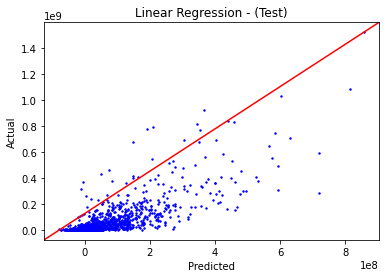

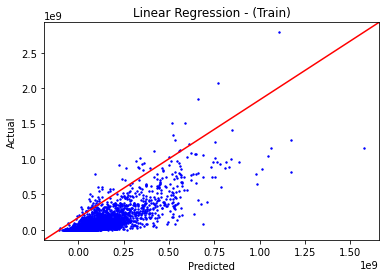

In [17]:
def linear_regression(X_train, Y_train, X_test, Y_test):
  """
  function to perform linear regression
  """

  # define the model
  model = LinearRegression()

  # fit the model on training data
  model.fit(X_train, Y_train)

  # predict train and test sets
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  
  return model, y_pred_train, y_pred_test

lr_model, lr_y_pred_train, lr_y_pred_test = linear_regression(X_train, Y_train, X_test, Y_test)

print_metrics(lr_model, lr_y_pred_train, lr_y_pred_test, X_train, Y_train, X_test, Y_test)

plot_for_bias_variance(lr_y_pred_test, lr_y_pred_train, Y_test, Y_train, "Linear Regression")

[ 9.09823399e+08 -3.74169170e+07  1.34185807e+09  9.45702331e+07
  1.10161026e+08 -3.61302799e+07 -2.82287762e+07  1.51569135e+07
 -1.00409586e+07 -3.21293227e+07 -1.17292672e+07  8.17662480e+07
  8.55169354e+05 -5.15832346e+07  3.25990669e+07  1.53228455e+07
  1.36753879e+07  2.51626731e+06  2.88416151e+07  7.84682360e+06
 -1.96444496e+07 -1.14062416e+07 -1.00462154e+07  1.96188730e+07
 -1.39023115e+07 -1.78603848e+07 -5.64953975e+06 -5.86197188e+06
  1.58629335e+06 -2.38780541e+07 -1.76872495e+07 -2.78883460e+06
  4.39434330e+06 -2.84539702e+07 -2.08650883e+07 -1.42172734e+06
 -2.01013445e+07  2.45606181e+08  5.76480341e+07]
Index(['budget', 'language', 'popularity', 'runtime', 'keyword', 'Day', 'Year',
       'Foreign', 'Thriller', 'History', 'Mystery', 'TV Movie', 'Music',
       'Western', 'Documentary', 'Family', 'Horror', 'Fantasy', 'Animation',
       'Romance', 'War', 'Crime', 'Action', 'Adventure', 'Drama',
       'Science Fiction', 'Comedy', 'is_holiday', 'is_near_holiday',


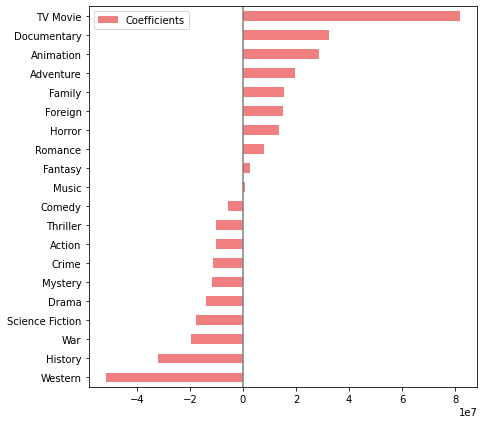

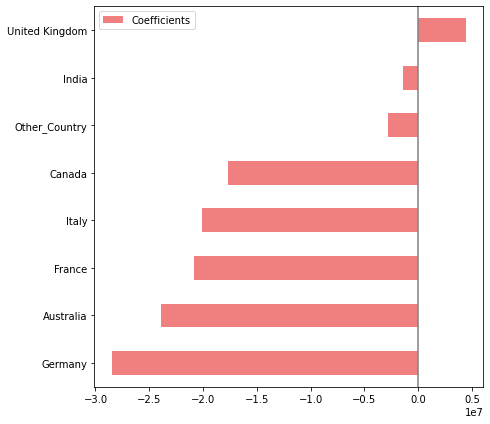

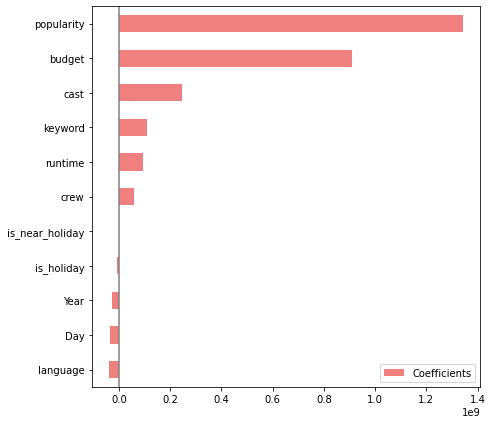

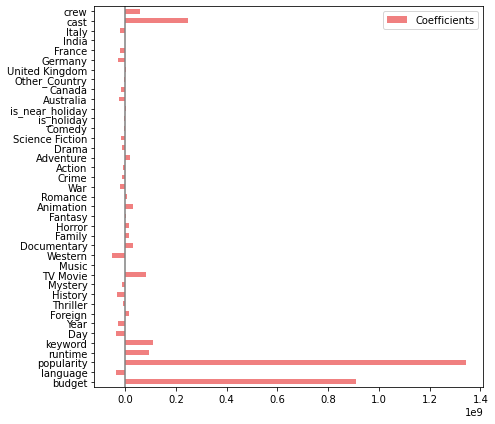

In [18]:
plot_coefficients(lr_model, "lightcoral")

# LASSO REGULARIZATION

In [11]:
from sklearn.linear_model import Lasso

Best suited alpha = 0.001
Training Dataset:
R2 Score =  0.629827055377389
RMSE =  104992888.7644449

Testing Dataset:
R2 Score =  0.5592068247196554
RMSE =  93581383.17965232

Cross Validation R2 Score = 0.6128959244103119


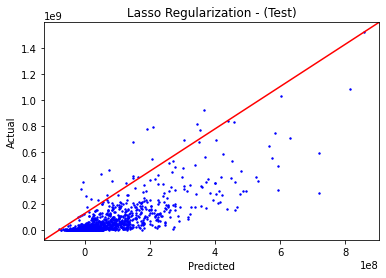

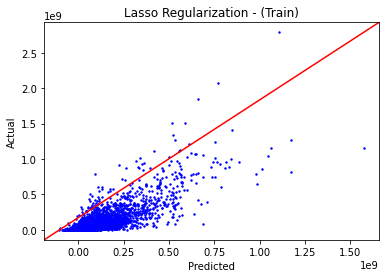

In [19]:
def get_alpha_lasso(X_train, Y_train):
  """
  function to find best regularization coefficient using `GridSearchCV` for
  Lasso Regression
  """
  alphas_to_search = np.logspace(-6, -3, 10)
  model = Lasso()
  lasso_gs = GridSearchCV(estimator=model, param_grid = dict(alpha = alphas_to_search))
  lasso_gs.fit(X_train, Y_train)
  alpha = lasso_gs.best_estimator_.alpha
  return alpha



def lasso_regularization(X_train, Y_train, X_test, Y_test):
  """
  function to perform lasso regularization
  """
  alpha = get_alpha_lasso(X_train, Y_train)
  print(f"Best suited alpha = {alpha}")
  
  model = Lasso(alpha=alpha)
  
  model.fit(X_train, Y_train)
  
  Y_pred_train = model.predict(X_train)
  
  Y_pred_test = model.predict(X_test)
  
  return model, Y_pred_train, Y_pred_test



model, Y_pred_train, Y_pred_test = lasso_regularization(X_train, Y_train, X_test, Y_test)

print_metrics(model, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)

plot_for_bias_variance(Y_pred_test, Y_pred_train, Y_test,Y_train, "Lasso Regularization")

[ 9.09823399e+08 -3.74169169e+07  1.34185807e+09  9.45702329e+07
  1.10161025e+08 -3.61302799e+07 -2.82287761e+07  1.51569132e+07
 -1.00409586e+07 -3.21293227e+07 -1.17292672e+07  8.17662436e+07
  8.55169338e+05 -5.15832345e+07  3.25990668e+07  1.53228455e+07
  1.36753879e+07  2.51626731e+06  2.88416151e+07  7.84682358e+06
 -1.96444495e+07 -1.14062416e+07 -1.00462154e+07  1.96188730e+07
 -1.39023115e+07 -1.78603848e+07 -5.64953975e+06 -5.86197185e+06
  1.58629333e+06 -2.38780540e+07 -1.76872494e+07 -2.78883459e+06
  4.39434329e+06 -2.84539702e+07 -2.08650882e+07 -1.42172725e+06
 -2.01013445e+07  2.45606181e+08  5.76480341e+07]
Index(['budget', 'language', 'popularity', 'runtime', 'keyword', 'Day', 'Year',
       'Foreign', 'Thriller', 'History', 'Mystery', 'TV Movie', 'Music',
       'Western', 'Documentary', 'Family', 'Horror', 'Fantasy', 'Animation',
       'Romance', 'War', 'Crime', 'Action', 'Adventure', 'Drama',
       'Science Fiction', 'Comedy', 'is_holiday', 'is_near_holiday',


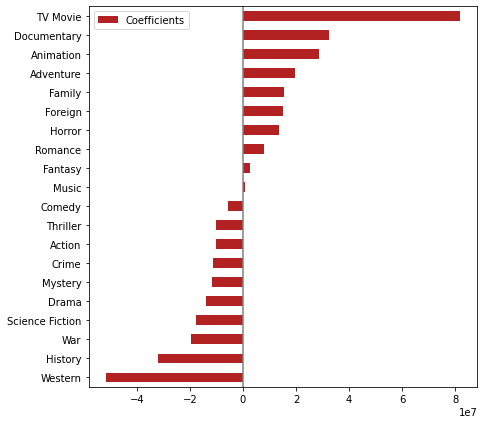

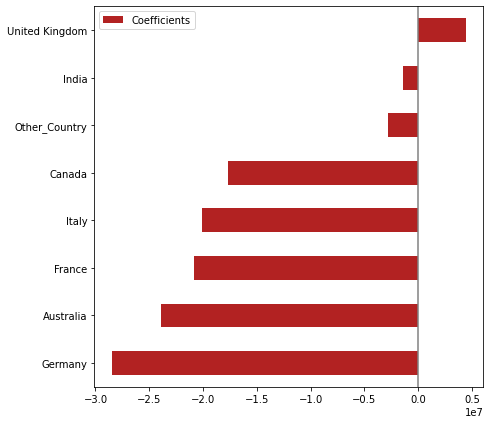

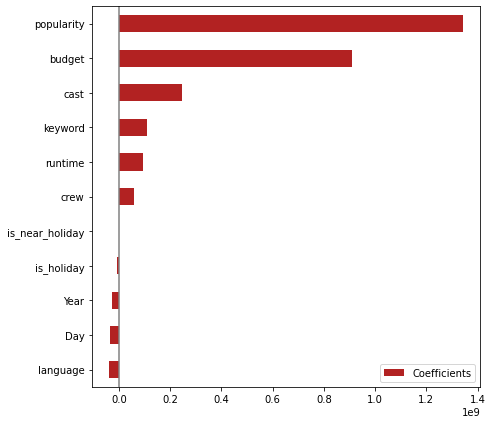

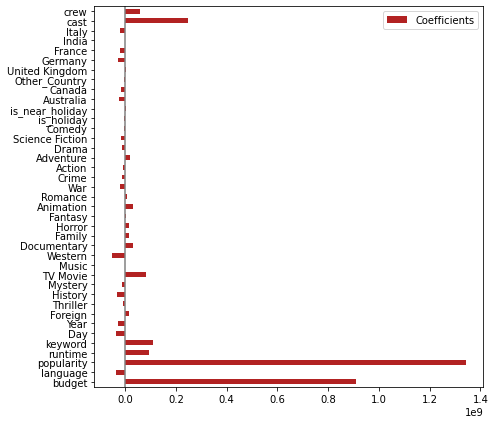

In [20]:
plot_coefficients(model, "firebrick")

#Ridge Regularisation

In [21]:
from sklearn.linear_model import Ridge

Best suited alpha = 0.1
Training Dataset:
R2 Score =  0.6297790485883838
RMSE =  104999696.67426588

Testing Dataset:
R2 Score =  0.5584418727119118
RMSE =  93662548.4978033

Cross Validation R2 Score = 0.6158372350556678


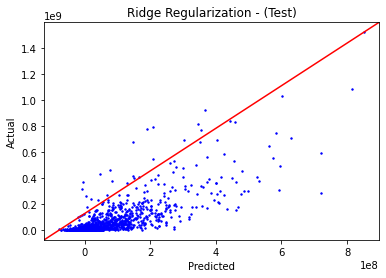

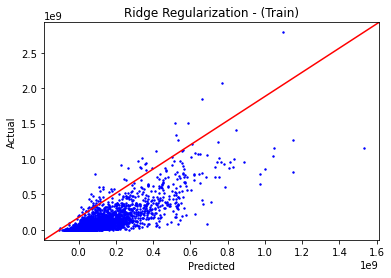

In [24]:
def get_alpha_ridge(X_train, Y_train):
  """
  function to find best regularization coefficient using `GridSearchCV` for 
  Ridge Regression
  """
  alphas_to_search = np.logspace(-6, -1, 10)
  model = Ridge()
  ridge_gs = GridSearchCV(estimator = model, param_grid = dict(alpha = alphas_to_search))
  ridge_gs.fit(X_train, Y_train)
  alpha = ridge_gs.best_estimator_.alpha
  return alpha

def ridge_regularization(X_train, Y_train, X_test, Y_test):
  """
  function to perform ridge regularization
  """
  alpha = get_alpha_ridge(X_train, Y_train)
  
  print(f"Best suited alpha = {alpha}")
  
  model = Ridge(alpha = alpha)
  
  model.fit(X_train, Y_train)
  
  Y_pred_train = model.predict(X_train)
  Y_pred_test = model.predict(X_test)
  
  return model, Y_pred_train, Y_pred_test



model, Y_pred_train, Y_pred_test = ridge_regularization(X_train, Y_train, X_test, Y_test)

print_metrics(model, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)

plot_for_bias_variance(Y_pred_test, Y_pred_train,Y_test,Y_train,"Ridge Regularization")

[ 9.07604013e+08 -3.71937632e+07  1.29668134e+09  9.62175998e+07
  1.10757119e+08 -3.64741773e+07 -2.69980770e+07  1.49138045e+07
 -1.00964448e+07 -3.22457651e+07 -1.16985092e+07  7.38985110e+07
  7.59612437e+05 -5.14443289e+07  3.22659493e+07  1.54618528e+07
  1.36625519e+07  2.73369190e+06  2.93472399e+07  7.81876050e+06
 -1.96432918e+07 -1.14347839e+07 -9.91229513e+06  1.98432889e+07
 -1.40101322e+07 -1.77040661e+07 -5.67410030e+06 -6.04565535e+06
  1.60868162e+06 -2.38064843e+07 -1.75869685e+07 -2.89870356e+06
  4.52855700e+06 -2.85425369e+07 -2.09843227e+07 -1.89052056e+06
 -1.99454848e+07  2.45656151e+08  5.96634833e+07]
Index(['budget', 'language', 'popularity', 'runtime', 'keyword', 'Day', 'Year',
       'Foreign', 'Thriller', 'History', 'Mystery', 'TV Movie', 'Music',
       'Western', 'Documentary', 'Family', 'Horror', 'Fantasy', 'Animation',
       'Romance', 'War', 'Crime', 'Action', 'Adventure', 'Drama',
       'Science Fiction', 'Comedy', 'is_holiday', 'is_near_holiday',


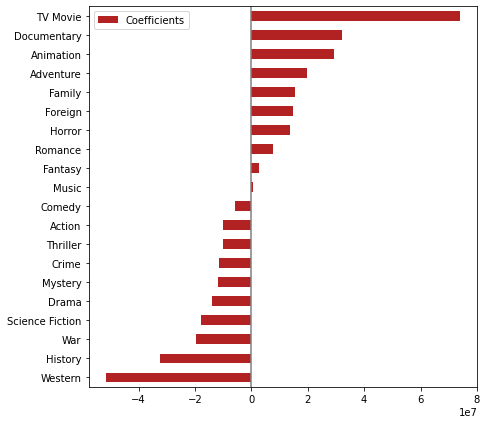

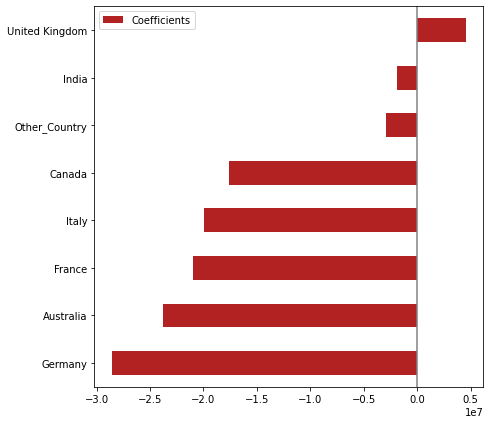

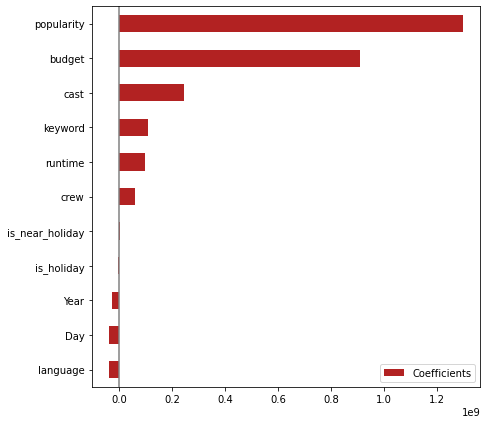

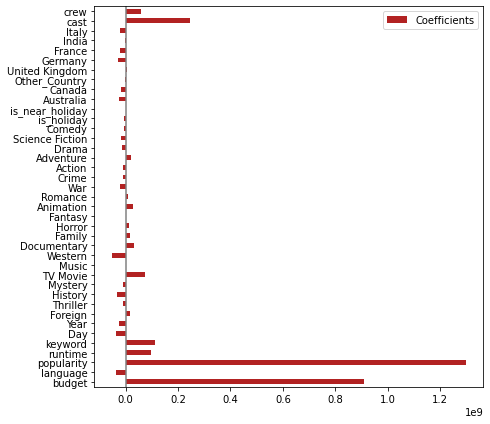

In [25]:
plot_coefficients(model, "firebrick")

# DECISION TREE

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [17]:
# do grid search on `DecisionTreeRegressor` to find best hyperparameters

regr = DecisionTreeRegressor()

grid = {}

grid['max_depth'] = np.arange(3, 16)
grid['min_samples_leaf'] = np.arange(5, 21)

cv = KFold(n_splits=3)

grid_search = GridSearchCV(estimator=regr, param_grid=grid, cv=cv, n_jobs = -1)

In [18]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])})

In [19]:
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

Best: 0.5989651141405162 using {'max_depth': 7, 'min_samples_leaf': 18}


Training Dataset:
R2 Score =  0.7151392417656444
RMSE =  92103017.98455113

Testing Dataset:
R2 Score =  0.5838981537479874
RMSE =  90922600.89481445

Cross Validation R2 Score = 0.5989651141405162


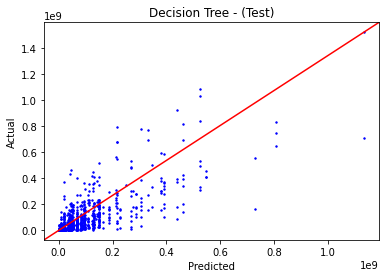

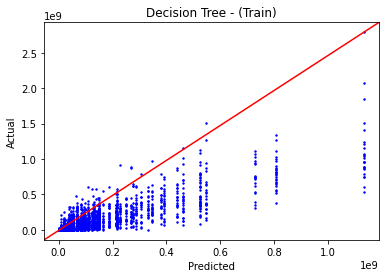

In [20]:
regr = DecisionTreeRegressor(random_state = 0, max_depth = 7, 
                             min_samples_leaf=18)

regr.fit(X_train, Y_train)

Y_pred_train = regr.predict(X_train)
Y_pred_test = regr.predict(X_test)


print_metrics(regr, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)

plot_for_bias_variance(Y_pred_test,Y_pred_train,Y_test,Y_train,"Decision Tree")


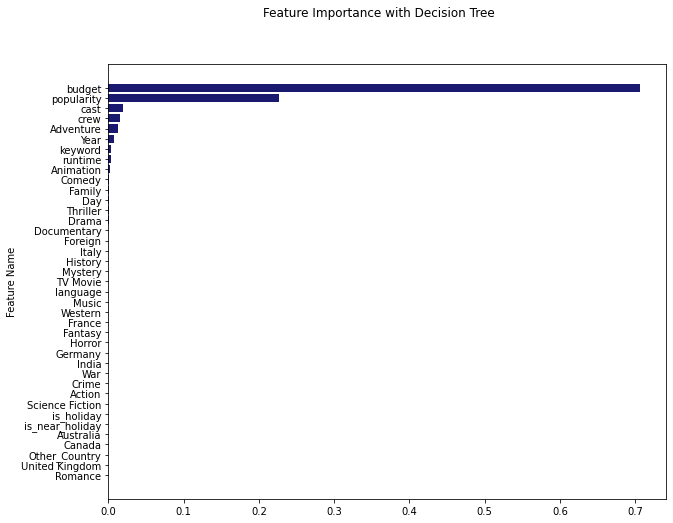

In [21]:
feature_importance(regr, "midnightblue", "Decision Tree")

In [22]:
plt.figure()
plt.figure(figsize=(300,160))

plot_tree(regr, filled=True, fontsize=150)

plt.show()

<Figure size 432x288 with 0 Axes>

In [23]:
print(f"Cross Validation R2 Score = {get_cv_score(regr, X_train, Y_train, X_test, Y_test)}")

Cross Validation R2 Score = 0.5989651141405162


#BAGGING

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [25]:
def bagging_dt(X_train,Y_train,X_test,Y_test,trees):
  """
  function to perform bagging on `DecisionTreeRegrssor`
  """

  dt = DecisionTreeRegressor(random_state = 0, max_depth = 7,min_samples_leaf=18)
  regr = BaggingRegressor(base_estimator =dt, n_estimators=trees,n_jobs=-1)

  regr.fit(X_train,Y_train)
  
  Y_pred_train=regr.predict(X_train)
  Y_pred_test=regr.predict(X_test)
  
  
  print_metrics(regr, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)
  
  plot_for_bias_variance(Y_pred_test,Y_pred_train,Y_test,Y_train,"Decision with Bagging Trees")
  
  return

Training Dataset:
R2 Score =  0.7204734030672113
RMSE =  91236605.0911262

Testing Dataset:
R2 Score =  0.6278149580915797
RMSE =  85990700.44258773

Cross Validation R2 Score = 0.6415858069421039


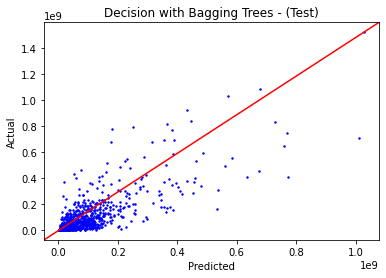

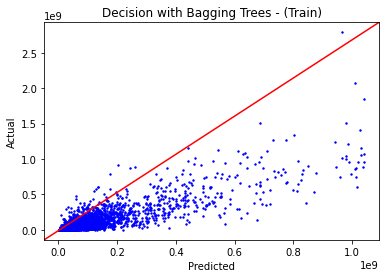

In [26]:
bagging_dt(X_train,Y_train,X_test,Y_test,150)

# RANDOM FORESTS

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
X_train_new = SelectKBest(chi2, k=20).fit_transform(X_train, Y_train)

In [ ]:
# Plot a 3D graph: cv score vs num_trees vs depth

def plot_num_trees_vs_depth_vs_loss():

  depths = np.arange(4, 20)
  num_trees = np.arange(100, 750, 50)

  fig = plt.figure(figsize = (10,10))
  ax = plt.axes(projection='3d')

  for depth in depths:
    
    scores = []

    for num_tree in num_trees:

      regr = RandomForestRegressor(max_depth = depth, 
                            n_estimators = num_tree, 
                            min_samples_leaf = 7)
      
      regr.fit(X_train, Y_train)

      y_pred = regr.predict(X_test)
  
      scores.append(get_cv_score(regr, X_train, Y_train, X_test, Y_test, 1))
    
    
    ax.plot3D(scores, num_trees, depth)

  
  ax.set_xlabel("R2 Score")
  ax.set_ylabel("Number of trees")
  ax.set_zlabel("Depth")

  plt.show()

  return



plot_num_trees_vs_depth_vs_loss()

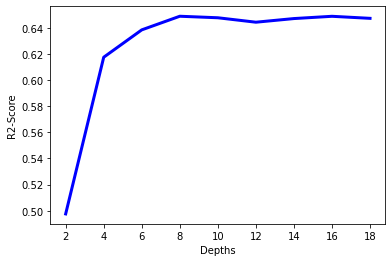

In [29]:
depths = np.arange(2, 20, 2)
scores = []

for depth in depths:
  regr = RandomForestRegressor(max_depth = depth, 
                            n_estimators = 700, 
                            min_samples_leaf = 7)
  
  regr.fit(X_train, Y_train)
  
  y_pred = regr.predict(X_test)
  
  scores.append(get_cv_score(regr, X_train, Y_train, X_test, Y_test, 1))


plt.plot(depths, scores, color='blue', linewidth=3)

plt.xlabel("Depths")
plt.ylabel("R2-Score")

plt.show()

In [ ]:
regr = RandomForestRegressor()

grid = {}

grid['max_depth'] = np.arange(8, 15)
grid['n_estimators'] = np.arange(800, 1400, 100)
grid['min_samples_leaf'] = np.arange(4, 11)

cv = KFold(n_splits=3)

grid_search = GridSearchCV(estimator=regr, param_grid=grid, cv=cv, n_jobs = -1)

In [ ]:
grid_search.fit(X_train, Y_train)

In [ ]:
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

Training Dataset:
R2 Score =  0.84751846006112
RMSE =  67385457.74744612

Testing Dataset:
R2 Score =  0.6526492418778147
RMSE =  83072284.66308445

Cross Validation R2 Score = 0.6722776795812425


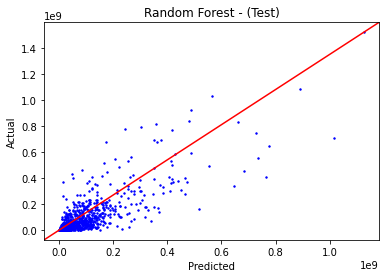

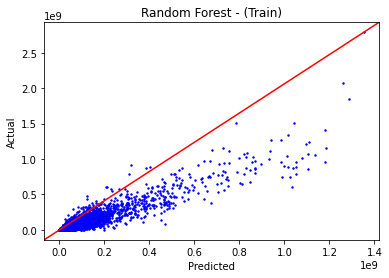

In [30]:
regr = RandomForestRegressor(max_depth = 10, 
                            n_estimators = 800, 
                            min_samples_leaf = 4)

regr.fit(X_train, Y_train)

Y_pred_train = regr.predict(X_train)
Y_pred_test = regr.predict(X_test)

print_metrics(regr, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)

plot_for_bias_variance(Y_pred_test, Y_pred_train, Y_test, Y_train, "Random Forest")

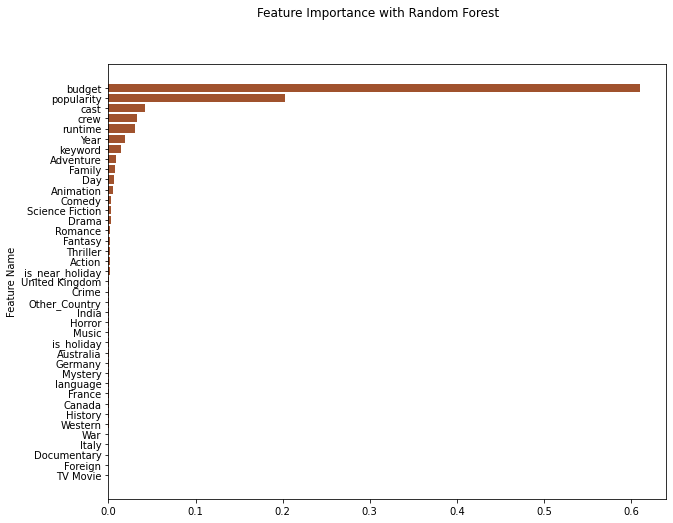

In [32]:
feature_importance(regr, "sienna", "Random Forest")

In [33]:
print(f"Cross Validation R2 Score = {get_cv_score(regr, X_train, Y_train, X_test, Y_test)}")

Cross Validation R2 Score = 0.672409696012309


# BOOSTING


### ADABOOSTED RANDOM FOREST

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = AdaBoostRegressor(base_estimator = RandomForestRegressor(max_depth = 10, 
                            n_estimators = 150,
                            min_samples_leaf = 4
                            ),
                          n_estimators = 100, 
                         learning_rate = 0.001, 
                         loss = "square")

regr.fit(X_train, Y_train)
y_pred_train = regr.predict(X_train)
y_pred_test = regr.predict(X_test)

print_metrics(regr, y_pred_train, y_pred_test, X_train, Y_train, X_test, Y_test)

In [ ]:
plot_for_bias_variance(y_pred_test,y_pred_train,Y_test,Y_train, "ADA Boost on Random Forest")

In [ ]:
print(f"Cross Validation R2 Score = {get_cv_score(regr, X_train, Y_train, X_test, Y_test)}")

### XGBOOSTED DECISION TREES

In [34]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

from math import floor, sqrt

In [35]:
regr = XGBRegressor(objective="reg:squarederror")

grid = {}

grid['max_depth'] = [4, 5, 6, 7, 8]
grid['learning_rate'] = [0.001, 0.01, 0.1]
grid['n_estimators'] = [600, 700, 800, 900, 1000]

cv = KFold(n_splits=3)

grid_search = GridSearchCV(estimator=regr, param_grid=grid, cv=cv, n_jobs = -1)

In [36]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBRegressor(objective='reg:squarederror'), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [600, 700, 800, 900, 1000]})

In [37]:
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

Best: 0.6758141007256953 using {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 700}


Training Dataset:
R2 Score =  0.8483411018325924
RMSE =  67203438.79024625

Testing Dataset:
R2 Score =  0.6527047083666976
RMSE =  83065651.72533172

Cross Validation R2 Score = 0.6758141007256953


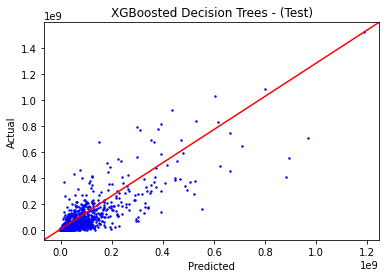

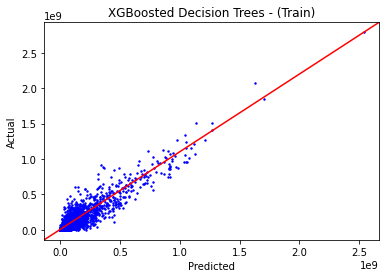

In [38]:
regr = XGBRegressor(max_depth = 4, learning_rate = 0.01, 
                    objective="reg:squarederror", n_estimators = 700)

regr.fit(X_train, Y_train)

Y_pred_train = regr.predict(X_train)
Y_pred_test = regr.predict(X_test)

print_metrics(regr, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)
plot_for_bias_variance(Y_pred_test,Y_pred_train,Y_test,Y_train,"XGBoosted Decision Trees")

In [39]:
print(f"Cross Validation R2 Score = {get_cv_score(regr, X_train, Y_train, X_test, Y_test)}")

Cross Validation R2 Score = 0.6758141007256953


In [ ]:
# FUTURE WORK:

# Can we improve this? This should work better than Boost on decision trees?

# XGBOOSTed Random Forest
M = X_train.shape[0]
regr = XGBRFRegressor(max_depth = 20, learning_rate = 1,
                    objective="reg:squarederror", n_estimators = 500, 
                    n_jobs = -1, num_parallel_tree = 200,
                    subsample=0.63, colsample_bynode=floor(sqrt(M))/M,
                    reg_lambda=0)

regr.fit(X_train, Y_train)

Y_pred_train = regr.predict(X_train)
Y_pred_test = regr.predict(X_test)

print_metrics(regr, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)

In [ ]:
print(f"Cross Validation R2 Score = {get_cv_score(regr, X_train, Y_train, X_test, Y_test)}")

### ADABOOSTED DECISION TREES

In [40]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
regr = AdaBoostRegressor()

grid = {}

grid['n_estimators'] = [100, 300, 500, 700, 900, 1100]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1]

cv = KFold(n_splits=3)

grid_search = GridSearchCV(estimator=regr, param_grid=grid, n_jobs=-1, cv=cv)

In [ ]:
grid_result = grid_search.fit(X_train, Y_train)

In [ ]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Training Dataset:
R2 Score =  0.6851713904322926
RMSE =  96826591.4592779

Testing Dataset:
R2 Score =  0.5345356617703034
RMSE =  96164601.34483103

Cross Validation R2 Score = 0.6159874241789237


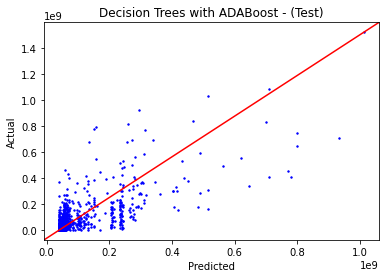

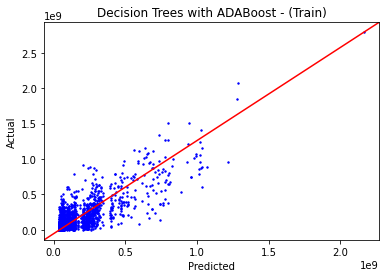

In [41]:
regr = AdaBoostRegressor(n_estimators = 300, 
                         learning_rate = 0.01, 
                         loss = "linear")

regr.fit(X_train, Y_train)

Y_pred_train = regr.predict(X_train)
Y_pred_test = regr.predict(X_test)

print_metrics(regr, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)
plot_for_bias_variance(Y_pred_test,Y_pred_train,Y_test,Y_train,"Decision Trees with ADABoost")

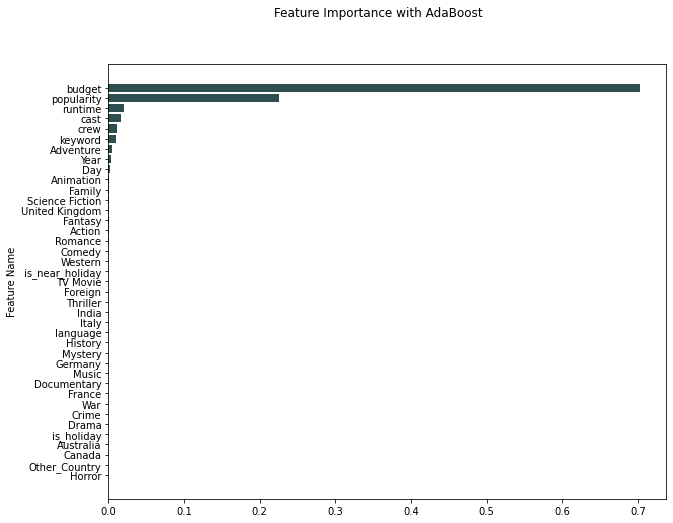

In [42]:
feature_importance(regr, "darkslategray", "AdaBoost")

In [43]:
print(f"Cross Validation R2 Score = {get_cv_score(regr, X_train, Y_train, X_test, Y_test)}")

Cross Validation R2 Score = 0.6178748900354523


In [ ]:
def get_pca(X_train,X_test):
  """
  function to apply PCA on training and testing sets
  """
  pca = PCA(0.90)
  
  pca.fit(X_train)
  
  X_train_pca = pca.transform(X_train)
  X_train_pca = pd.DataFrame(X_train_pca)
  
  X_test_pca = pca.transform(X_test)
  X_test_pca = pd.DataFrame(X_test_pca)
  
  return X_train_pca,X_test_pca

In [ ]:
def pr_and_pca(X_train, Y_train, X_test,Y_test):
  """
  function to 
  """
  X_train_pca,X_test_pca = get_pca(X_train,X_test)
  pr_model = PolynomialFeatures(degree=2)

  X_train_poly = pr_model.fit_transform(X_train_pca)
  X_train_poly = pd.DataFrame(X_train_poly)

  X_test_poly = pr_model.fit_transform(X_test_pca)
  X_test_poly = pd.DataFrame(X_test_poly)

  lr_pr_model = LinearRegression()
  
  lr_pr_model.fit(X_train_poly, Y_train)
  
  pr_y_pred_train = lr_pr_model.predict(X_train_poly)
  pr_y_pred_test = lr_pr_model.predict(X_test_poly)

  print_metrics(lr_pr_model, pr_y_pred_train, pr_y_pred_test, X_train_poly, Y_train, X_test_poly,Y_test)
  
  plot_for_bias_variance(pr_y_pred_test,pr_y_pred_train,Y_test,Y_train,"PCA")
  
  return


pr_and_pca(X_train, Y_train, X_test, Y_test)

# NEURAL NETWORKS

In [26]:
perm_count = 0
all_cols = X_train.columns.values.tolist()
perm_imp = np.zeros(len(all_cols))

def perm_importance(model, color, model_name, X_train, Y_train, X_test, Y_test):
  """
  function to find permutation importance 
  """
  global perm_count
  global perm_imp

  X = pd.concat([X_train, X_test], ignore_index = True)  
  Y = pd.concat([Y_train, Y_test], ignore_index = True)  

  all_cols = X_train.columns.values.tolist()
  perm = PermutationImportance(model).fit(X, Y)
  
  eli5.show_weights(perm, feature_names = all_cols)

  importances = perm.feature_importances_
  perm_imp += perm.feature_importances_
  perm_count += 1

  indices = np.argsort(importances)

  fig, ax = plt.subplots(figsize = (10, 8))
  ax.barh(range(len(importances)), importances[indices], color = color)
  ax.set_yticks(range(len(importances)))
  _ = ax.set_yticklabels(np.array(all_cols)[indices])
  fig.suptitle("Permutation Importance using " + model_name)
  ax.set_ylabel("Feature Name")

  return

In [27]:
from sklearn.neural_network import MLPRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training Dataset:
R2 Score =  0.7581256691552307
RMSE =  84869655.36800878

Testing Dataset:
R2 Score =  0.6067553266032438
RMSE =  88390065.03615196


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC


Cross Validation R2 Score = 0.6029420942530274


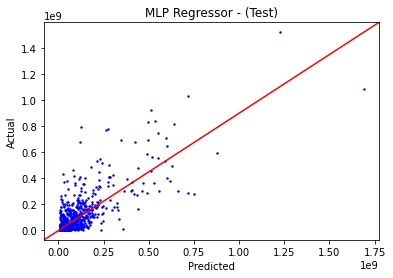

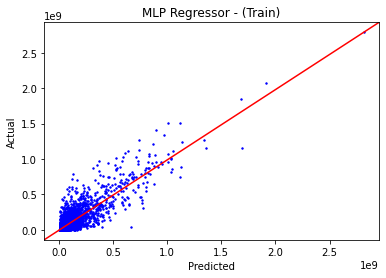

In [28]:
# best model found after tuning hyperparameters
mlp = MLPRegressor(random_state=1,
                    hidden_layer_sizes=(100, 50),
                    solver='lbfgs',
                    activation='relu',
                    alpha = 0.01,
                    max_iter = 100)

mlp.fit(X_train, Y_train)

Y_pred_train = mlp.predict(X_train)
Y_pred_test = mlp.predict(X_test)

print_metrics(mlp, Y_pred_train, Y_pred_test, X_train, Y_train, X_test, Y_test)

plot_for_bias_variance(Y_pred_test, Y_pred_train, Y_test, Y_train, "MLP Regressor")

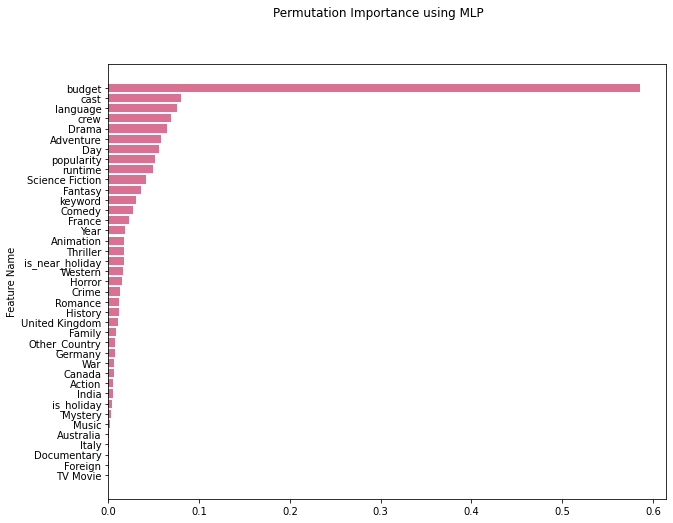

In [29]:
perm_importance(mlp, "palevioletred", "MLP", X_train, Y_train, X_test, Y_test)

In [30]:
def global_perm_imp(color):

  global perm_imp
  global perm_count
  
  perm_imp /= perm_count
  indices = np.argsort(perm_imp)
  all_cols = X_train.columns.values.tolist()

  fig, ax = plt.subplots(figsize = (10, 8))
  
  ax.barh(range(len(perm_imp)), perm_imp[indices], color = color)
  
  ax.set_yticks(range(len(perm_imp)))
  
  _ = ax.set_yticklabels(np.array(all_cols)[indices])
  
  fig.suptitle("Permutation Importance (avg over MLP, KRR and Stacking)")
  ax.set_ylabel("Feature Name")

# KERNEL REGRESSION

In [ ]:
from sklearn.kernel_ridge import KernelRidge

Train Error
RMSE =  68376598.78731413
R2 Score =  0.8429999134053419

Test Error
RMSE =  85731760.3562371
R2 Score =  0.6300530727603169

Cross Validation R2-score = 0.6450032941496643


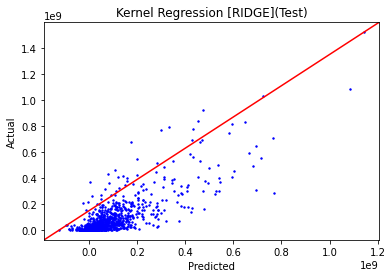

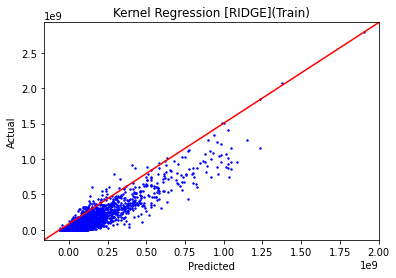

In [ ]:
krr = KernelRidge(alpha=0.01,
                  kernel='laplacian')

# list of valid kernels:
# [‘additive_chi2’, ‘chi2’, ‘linear’, ‘poly’, ‘polynomial’, ‘rbf’, ‘laplacian’, 
# ‘sigmoid’, ‘cosine’]

krr.fit(X_train, Y_train)

print_metrics(krr, krr.predict(X_train), krr.predict(X_test), X_train, Y_train, X_test, Y_test)
plot_for_bias_variance(krr.predict(X_test),krr.predict(X_train),Y_test,Y_train,"Kernel Regression [RIDGE]")

In [ ]:
# plot effect of regularization coefficients on score

train_scores = []
test_scores = []

alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

for alpha in alphas:
  krr = KernelRidge(alpha=alpha,
                    kernel='laplacian')

  krr.fit(X_train, Y_train)

  train_scores.append(krr.score(X_train, Y_train))
  test_scores.append(krr.score(X_test, Y_test))

plt.plot(alphas, train_scores, color='blue', linewidth=3)
plt.plot(alphas, test_scores, color='red', linewidth=3)
plt.title("Comparision of alpha for KRR")
plt.xlabel("alpha")
plt.ylabel("score")

plt.show()

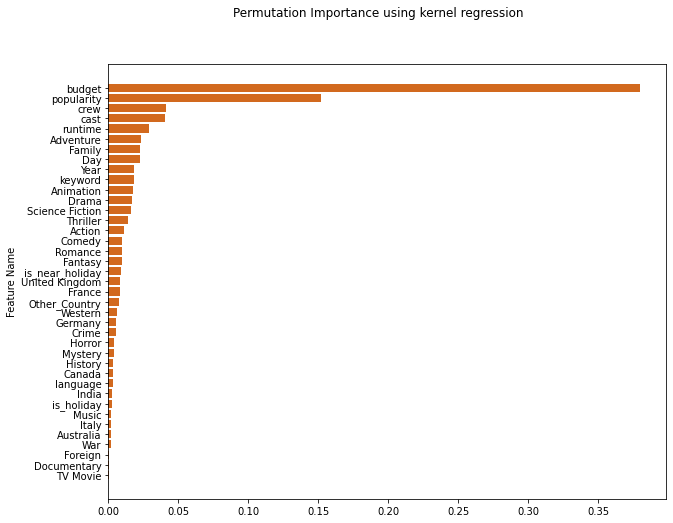

In [ ]:
perm_importance(krr, "chocolate", "kernel regression", X_train, Y_train, X_test, Y_test)

### ADABOOSTED KERNEL RIDGE REGRESSION

In [ ]:
krr = KernelRidge(alpha=0.05,
                    kernel='laplacian')

regr = AdaBoostRegressor(base_estimator=krr,
                         n_estimators = 10, 
                         learning_rate = 0.01, 
                         loss = "linear")

regr.fit(X_train, Y_train)


print("\n\n\n")
print(f"train score = {regr.score(X_train, Y_train)}")
print(f"test score = {regr.score(X_test, Y_test)}")
print("\n\n\n")

# plot_for_bias_variance(regr.predict(X_test),regr.predict(X_train),Y_test,Y_train,"NN")

# SVM REGRESSION

In [49]:
from sklearn.svm import SVR

In [ ]:
# gives a very poor R2 Score

kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
  svr = SVR(C=1.0, epsilon=0.2, gamma = "scale" , kernel = kernel)
  
  svr.fit(X_train, Y_train)
  
  print(f"train score = {svr.score(X_train, Y_train)}")
  print(f"test score = {svr.score(X_test, Y_test)}")
  
  plot_for_bias_variance(svr.predict(X_test),svr.predict(X_train),Y_test,Y_train,"NN")

  print("\n\n\n")

# KNN REGRESSION

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
kneigh = KNeighborsRegressor()
kfold = KFold(n_splits=3, shuffle=True, random_state=13)
candidates = [{'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,30,20,101], 
               'weights': ['uniform','distance']}]

grid = GridSearchCV(estimator=kneigh, param_grid=candidates, cv=kfold, scoring='r2')


0.4011905948030876
KNeighborsRegressor(n_neighbors=8, weights='distance')
{'n_neighbors': 8, 'weights': 'distance'}


In [ ]:
grid.fit(X_train, Y_train)

In [ ]:
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

In [ ]:
neighbours = [2,4,6,8,9,10,11,12,13,14,15,16,18,20,30,45,100]
cv_scores =[]
train_scores =[]
test_scores = []
for i in neighbours:
  kneigh = KNeighborsRegressor(n_neighbors=i, weights='uniform')
  kneigh.fit(X_train, Y_train)
  # print("\n\n\n")
  print(i)
  cv_scores.append(get_cv_score(kneigh, X_train, Y_train, X_test, Y_test))
  train_scores.append(kneigh.score(X_train, Y_train))
  test_scores.append(kneigh.score(X_test, Y_test))
  # print("\n\n\n")
  # plot_for_bias_variance(kneigh.predict(X_test),kneigh.predict(X_train),Y_test,Y_train,"KNN")
  

2
4
6
8
9
10
11
12
13
14
15
16
18
20
30
45
100


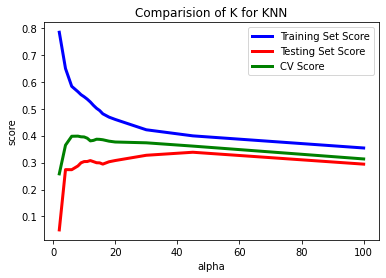

In [ ]:
plt.plot(neighbours, train_scores, color='blue', linewidth=3, label = "Training Set Score")
plt.plot(neighbours, test_scores, color='red', linewidth=3, label = "Testing Set Score")

plt.plot(neighbours, cv_scores, color='green', linewidth=3, label = "CV Score")

plt.title("Comparision of K for KNN")

plt.xlabel("alpha")
plt.ylabel("score")

plt.legend()

plt.show()

Train Error
RMSE =  114073082.99367146
R2 Score =  0.5630303619762221

Test Error
RMSE =  118983766.49004656
R2 Score =  0.28742371109420817

Cross Validation R2-score = 0.39810791735440093


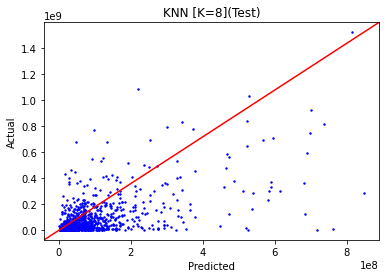

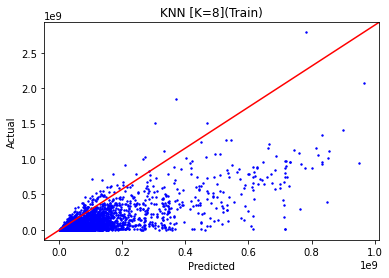

In [ ]:
kneigh = KNeighborsRegressor(n_neighbors=8, weights='uniform')

kneigh.fit(X_train, Y_train)

print_metrics(kneigh, kneigh.predict(X_train), kneigh.predict(X_test), X_train, Y_train, X_test, Y_test)

plot_for_bias_variance(kneigh.predict(X_test),kneigh.predict(X_train),Y_test,Y_train,"KNN [K=8]")

### Stacking RF with Kernel Regression

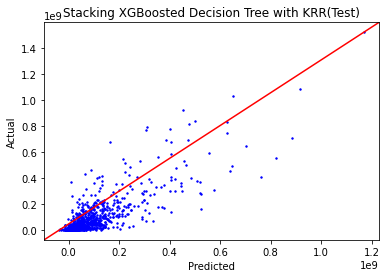

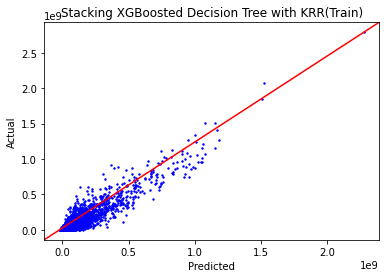

Train Error
RMSE =  65367394.434259474
R2 Score =  0.8565147522337178

Test Error
RMSE =  81178890.90685984
R2 Score =  0.6683025224248873

Cross Validation R2-score = 0.6804497976100339


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn import linear_model
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge


regr1 =XGBRegressor(max_depth = 4, learning_rate = 0.01, objective="reg:squarederror", n_estimators = 700)
regr2 = KernelRidge(alpha=0.01,kernel='laplacian')

estimators = [('RF', regr1),('Kernel', regr2) ]

regr = StackingRegressor( estimators=estimators , final_estimator = linear_model.LinearRegression() )

regr.fit(X_train, Y_train)

plot_for_bias_variance(regr.predict(X_test),regr.predict(X_train),Y_test,Y_train,"Stacking XGBoosted Decision Tree with KRR")

print_metrics(regr, regr.predict(X_train), regr.predict(X_test), X_train, Y_train, X_test, Y_test)

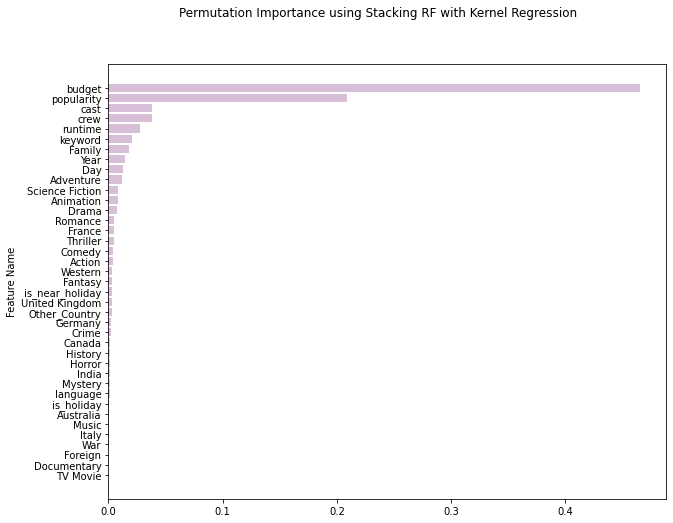

In [ ]:
perm_importance(regr, "thistle", "Stacking RF with Kernel Regression", X_train, Y_train, X_test, Y_test)

# FEATURE VARIATION

In [31]:
# STEPS TO ANALYZE:
# 1) define the model and train it
# 2) make predictions using `feature_variation` function
# 3) plot the result using plot `plot_feature_variation` function

In [32]:
# `trained` final model
# `df` is the dataset we're doing our analysis on; for now it's assumed to be X_test
# `idx` is the index of the feature

def feature_variation(model, df, idx, start, end, jump, scaler = None, feature_names = None):
  """
  function to vary a feature at index `idx` for the passed dataset `df` 
  and return `predictions` at different values i.e. start:end:jump
  """
  
  if(scaler is not None and feature_names is None):
    raise Error("feature_names is None!")

  X_test = df.copy()
  
  feature = X_test.columns.values[idx]
  print(feature)

  predictions = pd.DataFrame()

  # for all the valid values in 
  for value in np.arange(start, end, jump):
    
    if(scaler is not None):
      X_test = scaler.inverse_transform(X_test)
      X_test = pd.DataFrame(X_test, columns=feature_names)

    X_test[feature] = value

    if(scaler is not None):
      X_test = scaler.transform(X_test)
      X_test = pd.DataFrame(X_test, columns=feature_names)

    pred = pd.DataFrame(model.predict(X_test))

    predictions = pd.concat([predictions, pred], axis = 1)

  return predictions




def plot_feature_variation(predictions, idx, start, end, jump, feature = None):
  """
  function to plot avg of `predictions`
  """
  
  if(feature is None):
    feature = "feature"
  
  y_list = np.array(predictions.sum()) / predictions.shape[0]
  x_list = np.arange(start, end, jump)
  plt.plot(x_list, y_list)
  
  plt.title('analysis for ' + feature)
  plt.xlabel(feature)
  plt.ylabel('predicted revenue')
  plt.show()


In [42]:
from sklearn.ensemble import StackingRegressor
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge

# (1) define and train models

# Train `XGBRegressor`
model = XGBRegressor(objective="reg:squarederror",
                     max_depth = 4,
                     learning_rate = 0.01,
                     n_estimators = 700)

model.fit(X_train, Y_train)


# Train `StackingRegressor`
regr1 = XGBRegressor(max_depth = 4, learning_rate = 0.01, objective="reg:squarederror", n_estimators = 700)
regr2 = KernelRidge(alpha=0.01,kernel='laplacian')
estimators = [('RF', regr1),('Kernel', regr2) ]

regr = StackingRegressor( estimators=estimators , final_estimator = linear_model.LinearRegression() )

regr.fit(X_train, Y_train)


StackingRegressor(estimators=[('RF',
                               XGBRegressor(learning_rate=0.01, max_depth=4,
                                            n_estimators=700,
                                            objective='reg:squarederror')),
                              ('Kernel',
                               KernelRidge(alpha=0.01, kernel='laplacian'))],
                  final_estimator=LinearRegression())

popularity


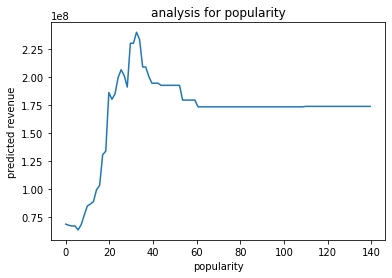

In [43]:
# This cell is for models that were trained WITHOUT scaling

column = "popularity"
idx = 2

start = X_test[column].min()
end = X_test[column].max()
jump = (end-start)/100

predictions = feature_variation(model, X_train, idx, start, end, jump)
plot_feature_variation(predictions, idx, start, end, jump, column)


In [ ]:
# # This cell is for models that were trained WITH scaling

# define `krr` = KernelRidgeRegressor

# predictions = feature_variation(krr, X_train_normalized, idx, start, end, jump, scaler, feature_names)
# plot_feature_variation(predictions, idx, start, end, jump, column)

budget  language  popularity  runtime  ...  India  Italy  cast  crew
4898   3800000       0.0    0.072704      0.0  ...    0.0    0.0     1     0
1825  12000000       1.0   10.753445     96.0  ...    0.0    0.0    13    29
2781  85000000       1.0    2.238808    104.0  ...    0.0    0.0     9    44
5216  40000000       1.0    0.755710    107.0  ...    0.0    0.0     4    21
1928   1750000       1.0    4.250819    109.0  ...    0.0    1.0     3     4
...        ...       ...         ...      ...  ...    ...    ...   ...   ...
1342  75000000       1.0    0.954467    104.0  ...    0.0    0.0    14    20
4145  13400000       1.0    1.223071    100.0  ...    0.0    0.0     9     2
2354  80000000       1.0   10.796939    129.0  ...    0.0    0.0    23    50
4710   2800000       0.0    0.709452    175.0  ...    1.0    0.0     1     5
756     800000       1.0   11.846960     93.0  ...    0.0    0.0     5     7

[1064 rows x 39 columns]

In [ ]:
predictions = feature_variation(regr, X_train, idx, start, end, jump)
plot_feature_variation(predictions, idx, start, end, jump, column)

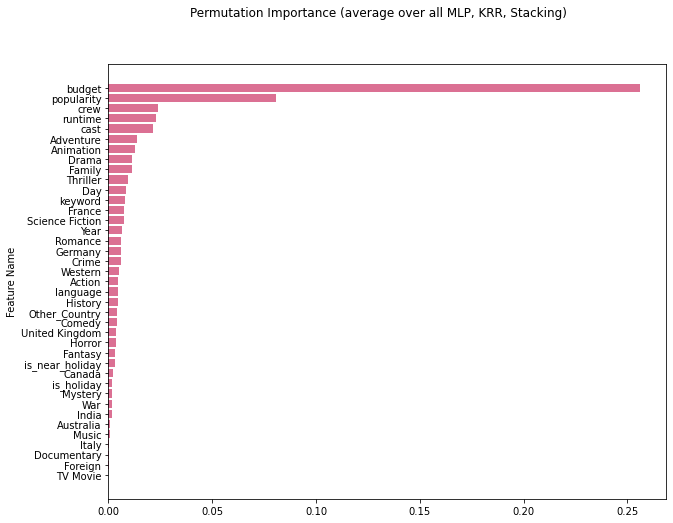

In [ ]:
global_perm_imp("palevioletred")